## JWST Pipeline Validation Testing Notebook: NIRISS/SOSS Time Series Observation
**Instruments affected**: NIRISS

### Table of Contents
1. [Imports](#Imports_ID)

2. [Introduction](#intro)

3. [The `group_scale` step](#groupscale)

4. [The `dq_init` step](#dq_init)

5. [The `saturation` step](#saturation)

6. [The `superbias` step](#superbias)

7. [The `refpix` step](#refpix)

8. [The `linearity` step](#linearity)

9. [The `darkcurrent` step](#dc)

10. [The `jump` step](#jump)

11. [The `ramp_fitting` step](#ramp_fitting)

12. [The `gain_scale` step](#gain_scale)

### <a id=#Imports_ID>Imports</a>

Here are the lirbaries being imported here and why:

- `numpy` for numerical calculations.
- `matplotlib.pyplot` for plots.
- `astropy.io.fits` for importing fits files.
- `jwst.pipeline.calwebb_detector1` for using the CalWebb Detector 1 stage.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from jwst.pipeline import calwebb_detector1
from jwst import datamodels

Version of the pipeline we are testing:

In [4]:
import jwst
print(jwst.__version__)

0.16.1


## <a id='intro'> Introduction </a>

In this notebook we'll be testing that the Stage 1 of the CalWebb Detector pipeline works as intended as a whole. We'll stop after every step to quickly check that the results make sense. The whole set of steps ran by TSOs by this first Stage of the CalWebb Pipeline can be found [<a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1">here</a>]. In what follows, we'll have one section associated to each step, calibrating the data sequentially and exploring the outputs accordingly.

## <a id='groupscale'> The `group_scale` step </a>

We first test and validate the `group_scale` step. This steps rescales pixel values in the raw JWST science data products, in case frame averaging did not result in proper downlinked values. In theory this step shouldn't do anything to the NIRISS/SOSS pixel values, because for NIRISS/SOSS a group is simply one frame. Let's test that this is indeed the case.

We call this individual step, then, and save the results to a folder called `output`:

In [3]:
calwebb_detector1.group_scale_step.GroupScaleStep.call('data_k2-141_uncal.fits', output_dir='output',save_results=True)

2020-07-24 09:18:29,585 - CRDS - ERROR -  Error determining best reference for 'pars-groupscalestep'  =   Unknown reference type 'pars-groupscalestep'
2020-07-24 09:18:29,593 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2020-07-24 09:18:30,233 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args ('data_k2-141_uncal.fits',).
2020-07-24 09:18:30,235 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-24 09:18:33,393 - stpipe.GroupScaleStep - INFO - NFRAMES=1 is a power of 2; correction not needed
2020-07-24 09:18:33,395 - stpipe.GroupScaleStep - INFO - Step will be skipped
2020-07-24 09:18:33,433 - stpipe.GroupScaleStep - WARNING - /Users/nespinoza/anaconda3/lib/python3.7/si

<RampModel(308, 3, 256, 2048) from data_k2-141_groupscalestep.fits>

In [5]:
hdul = fits.open('data_k2-141_uncal.fits')
print(hdul.info())
hdul_group_scale = fits.open('output/data_k2-141_groupscalestep.fits')
print(hdul_group_scale.info())

Filename: data_k2-141_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 3, 308)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 3, 308)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [1528B]   
  6  STAR          1 ImageHDU        10   (1221, 2)   float64   
  7  PLANET        1 ImageHDU        30   (1000, 2)   float64   
None
Filename: output/data_k2-141_groupscalestep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 Ima

There is a difference of 124B in the `ASDF` name, and also this changes of position when applying the pipeline. This is normal.

Note the step was skipped; not sure if this is a simulator problem (i.e., this needs the `frame_divisor` in the headers as well as the `nframes`). In any case, let's load the input data (`data_uncal.fits`) and resulting output from the step (`output/data_groupscalestep.fits`) and compute the difference between the values from both. The expectation is that they return the exact same thing:

In [5]:
data, group_scale = hdul['SCI'].data, hdul_group_scale['SCI'].data

In [6]:
difference = data-group_scale

In [7]:
idx = np.where(difference.flatten() == 0.)[0]
print(len(idx),'total zeroes.',difference.shape[0]*difference.shape[1]*difference.shape[2]*difference.shape[3],' flux measuremenents.')

484442112 total zeroes. 484442112  flux measuremenents.


**Indeed, the step does not do anything. Both outputs are exactly equal, as expected**. What about the headers? To check this out, let's use `fits.HeaderDiff`:

In [8]:
results = fits.HeaderDiff(hdul['SCI'].header, hdul_group_scale['SCI'].header)
results.report()

''

All is good --- no difference in the headers either. <font color='green'>**We consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='dq_init'> The `dq_init` step </a>

We now turn our attention to the next step in Stage 1, which is the `dq_init` step. This step populates the Data Quality (DQ) mask, so each pixel has an associated DQ flag to it. Let's run it on our dataset which was already passed through the `groups_scale` step:

In [9]:
calwebb_detector1.dq_init_step.DQInitStep.call('output/data_k2-141_groupscalestep.fits', output_dir='output',save_results=True)

2020-07-24 09:19:08,562 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2020-07-24 09:19:08,565 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2020-07-24 09:19:09,081 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('output/data_k2-141_groupscalestep.fits',).
2020-07-24 09:19:09,083 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-24 09:19:12,547 - stpipe.DQInitStep - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_niriss_mask_0013.fits
2020-07-24 09:19:17,194 - stpipe.DQInitStep - WARNING - Keyword CDP_WARM does not correspond to an existing DQ mnemonic, so will be ignored
2020-07-24 09:19:17,196 -

<RampModel(308, 3, 256, 2048) from data_k2-141_dqinitstep.fits>

The step finished without crashing, but as it is said above, there are some errors and warnings worth noting:
1. There is a CRDS ERROR "Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'"
2. `CDP_WARM` and `CDP_NOISY` do not correspond to existing `DQ` mnemonics, so they are ignored (this is normal, see below).
3. There is also a WARNING with the `T_SECONDARY` Keyword. It appears it is greater than 8 characters, or contains characters not allowed by the FITS standard.

Let's take a look at the `hdul`'s of both the uncal data and the `dqinit` products:

In [6]:
print(hdul_group_scale.info())
hdul_dqinit = fits.open('output/data_k2-141_dqinitstep.fits')
print(hdul_dqinit.info())

Filename: output/data_k2-141_groupscalestep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 3, 308)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 3, 308)   float32   
  5  STAR          1 ImageHDU        10   (1221, 2)   float64   
  6  PLANET        1 ImageHDU        30   (1000, 2)   float64   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [1649B]   
None
Filename: output/data_k2-141_dqinitstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      68   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ

Similar as with the `group_scale` step, now there are extra 143 elements on the ASDF BinTableHDU. Let's ommit that and go to the data directly. There should be no difference on the `SCI`, as above:

In [7]:
difference2 = hdul_dqinit['SCI'].data - hdul_group_scale['SCI'].data

In [8]:
idx2 = np.where(difference2.flatten() == 0.)[0]
print(len(idx2),'total zeroes.',difference2.shape[0]*difference2.shape[1]*difference2.shape[2]*difference2.shape[3],' flux measuremenents.')

484442112 total zeroes. 484442112  flux measuremenents.


This is good. Now, what _should_ change are the `PIXELDQ`. `GROUPDQ` should not change. Let's check `PIXELDQ` out first:

In [9]:
difference_pixelDQ = hdul_dqinit['PIXELDQ'].data - hdul_group_scale['PIXELDQ'].data

In [10]:
idx_pixelDQ = np.where(difference_pixelDQ.flatten() == 0.)[0]
print(len(idx_pixelDQ),'pixels did not change.',\
      difference_pixelDQ.shape[0]*difference_pixelDQ.shape[1],'pixels in each integration.',\
     difference_pixelDQ.shape[0]*difference_pixelDQ.shape[1]-len(idx_pixelDQ),'pixels changed.')

508196 pixels did not change. 524288 pixels in each integration. 16092 pixels changed.


Good! Now, let's check the third group of the first integration only for `GROUPDQ`:

In [11]:
difference_groupDQ = hdul_dqinit['GROUPDQ'].data[0,2,:,:] - hdul_group_scale['GROUPDQ'].data[0,2,:,:]

In [12]:
idx_groupDQ = np.where(difference_groupDQ.flatten() == 0.)[0]
print(difference_groupDQ.shape)
print(len(idx_groupDQ),'pixels did not change.',\
      difference_groupDQ.shape[0]*difference_groupDQ.shape[1],'pixels the integration.',\
     difference_groupDQ.shape[0]*difference_groupDQ.shape[1]-len(idx_groupDQ),'pixels changed.')

(256, 2048)
524288 pixels did not change. 524288 pixels the integration. 0 pixels changed.


Good! Now let's search the unique values of elements in the `PIXELDQ` image:

In [13]:
def unique_values(x):
    values = []
    for i in range(len(x)):
        if x[i] not in values:
            values.append(x[i])
    return values
        
uv = unique_values(hdul_dqinit['PIXELDQ'].data.flatten())

In [14]:
print(uv)

[2147483648, 0, 16777216, 5242880, 17825792, 1064960, 32768, 16384, 2147614720, 1073741824, 2048, 1074790400, 1024, 1081344, 1048576, 1049600]


Good! These are results from bitwise operations. Let's check how the reference bad pixel mask looks like in comparison with the `PIXELDQ`:

Filename: data/jwst_niriss_mask_0013.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   ()      
  1  DQ            1 ImageHDU        67   (2048, 2048)   int16 (rescales to uint16)   
  2  DQ_DEF        1 BinTableHDU     67   12R x 4C   [J, J, 40A, 80A]   
None
[( 0,    1, 'BAD_REF_PIXEL', 'Used only for bad reference pixels.')
 ( 1,    2, 'UNRELIABLE_SLOPE', 'Noisy pixels.')
 ( 2,    4, 'TELEGRAPH', 'RTN pixels.') ( 3,    8, 'HOT', 'Hot pixels.')
 ( 4,   16, 'RC', 'RC pixels.') ( 5,   32, 'DEAD', 'Unresponsive pixels.')
 ( 6,   64, 'UNRELIABLE_BIAS', 'Bad pedestal p[ixels.')
 ( 7,  128, 'OTHER_BAD_PIXEL', 'Other types of bad pixels such as random offset pixels.')
 ( 8,  256, 'NO_LIN_CORR', 'Pixels where the linearity coefficients were not determined.')
 ( 9,  512, 'CDP_WARM', 'Warm pixels, still OK for science.')
 (10, 1024, 'CDP_NOISY', 'Noisy pixels, still OK for science.')
 (11, 2048, 'REFERENCE_PIXEL', 'Reference pixels.')]

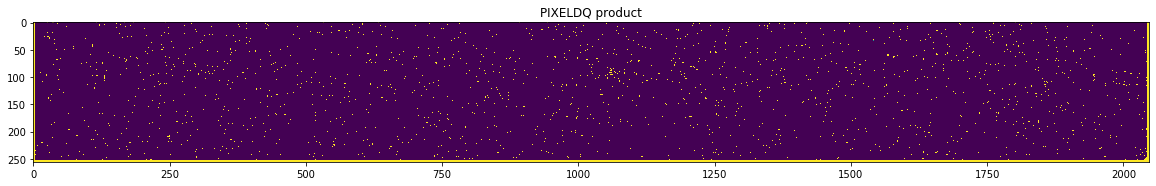

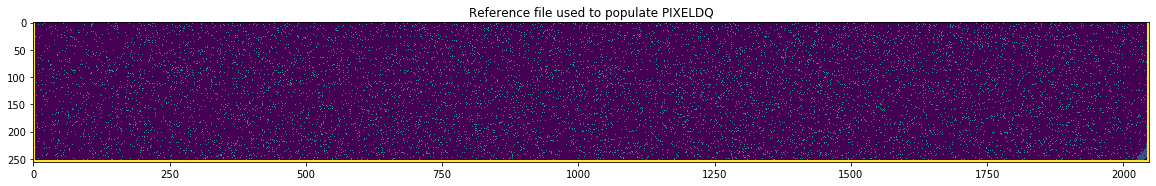

In [15]:
hdul_badpixelmask = fits.open('data/jwst_niriss_mask_0013.fits')
print(hdul_badpixelmask.info())
print(hdul_badpixelmask['DQ_DEF'].data)
plt.figure(figsize=(20,10))
plt.title('PIXELDQ product')
im = plt.imshow(hdul_dqinit['PIXELDQ'].data)
im.set_clim(0,2048)
plt.figure(figsize=(20,10))
plt.title('Reference file used to populate PIXELDQ')
im = plt.imshow(hdul_badpixelmask['DQ'].data[-256:,:])
im.set_clim(0,2048)

Note the pipeline product is much less populated. This is because the `CDP_WARM` and `CDP_NOISY` flags are not propagated, as these are not recognized by the pipeline explicitly. These are just "extra" flags from the reference files. Let's remove those from the reference files and see how these images look like without them:

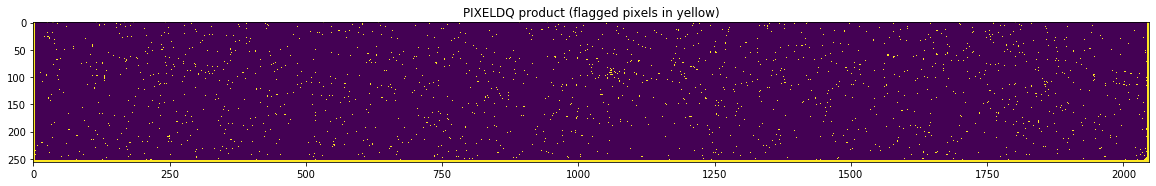

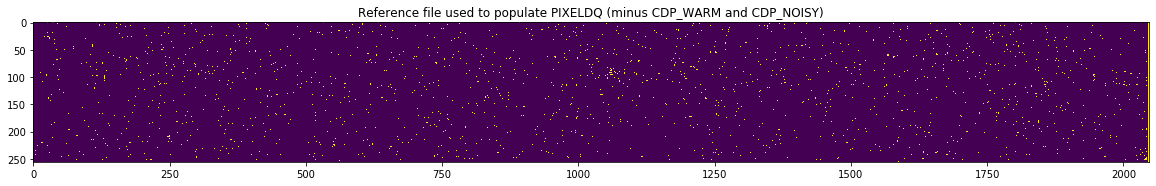

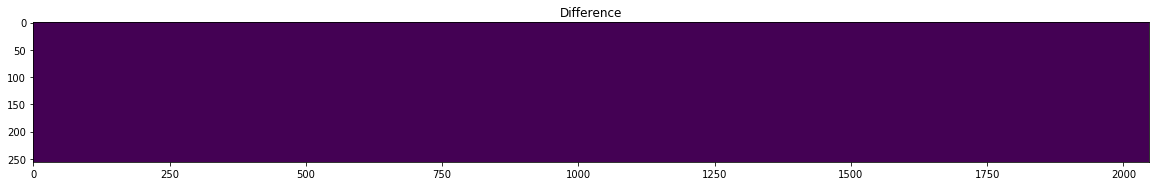

In [23]:
idx = np.where(hdul_badpixelmask['DQ'].data==512)
hdul_badpixelmask['DQ'].data[idx] = 0.
idx = np.where(hdul_badpixelmask['DQ'].data==1024)
hdul_badpixelmask['DQ'].data[idx] = 0.

# Let's fill with ones all pixels marked as > 0 in PIXELDQ:
pix_dq = np.zeros(hdul_dqinit['PIXELDQ'].data.shape)
idx_pixel = np.where(hdul_dqinit['PIXELDQ'].data>0)
pix_dq[idx_pixel] = 1.
# Let's do the same for ref mask:
mask_dq = np.zeros(hdul_badpixelmask['DQ'].data.shape)
idx_pixel = np.where(hdul_badpixelmask['DQ'].data>0)
mask_dq[idx_pixel] = 1.
plt.figure(figsize=(20,10))
plt.title('PIXELDQ product (flagged pixels in yellow)')
im = plt.imshow(pix_dq)
im.set_clim(0,1)
plt.figure(figsize=(20,10))
plt.title('Reference file used to populate PIXELDQ (minus CDP_WARM and CDP_NOISY)')
im = plt.imshow(mask_dq[-256:,:])
plt.figure(figsize=(20,10))
plt.title('Difference')
im = plt.imshow(mask_dq[-256:,:] - pix_dq)
im.set_clim(0,1)


They match perfectly. <font color='green'>**We consider the step validated from the NIRISS/SOSS point of view.**</font>


## <a id='saturation'> The `saturation` step </a>

This step simply checks which pixels are saturated in a given exposure. Let's run it:

In [20]:
calwebb_detector1.saturation_step.SaturationStep.call('output/data_k2-141_dqinitstep.fits', output_dir='output',save_results=True)

2020-07-24 09:19:54,409 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'
2020-07-24 09:19:54,412 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2020-07-24 09:19:54,944 - stpipe.SaturationStep - INFO - Step SaturationStep running with args ('output/data_k2-141_dqinitstep.fits',).
2020-07-24 09:19:54,946 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-24 09:19:58,091 - stpipe.SaturationStep - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_niriss_saturation_0010.fits
2020-07-24 09:20:29,740 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match science data
2020-07

<RampModel(308, 3, 256, 2048) from data_k2-141_saturationstep.fits>

The step finished without crashing, but as with the `dq_init` step, there are some errors and warnings worth noting:
1. There is a CRDS ERROR "Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'"
2. The same warning about `T_SECONDARY` Keyword shows up. 

Let's take a look at the `hdul`'s of both the `dqinit` and `saturation` products:

In [154]:
print(hdul_dqinit.info())
hdul_saturation = fits.open('output/data_k2-141_saturationstep.fits')
print(hdul_saturation.info())

Filename: output/data_k2-141_dqinitstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      68   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 3, 308)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 3, 308)   float32   
  5  STAR          1 ImageHDU        10   (1221, 2)   float64   
  6  PLANET        1 ImageHDU        30   (1000, 2)   float64   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [1792B]   
None
Filename: output/data_k2-141_saturationstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      73   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ

Almost the exact same thing. If there are any saturated values, they should appear in the `GROUPDQ` arrays. Let's compare and see if there are any detected:

In [22]:
difference_saturation = hdul_dqinit['GROUPDQ'].data - hdul_saturation['GROUPDQ'].data

In [23]:
idx_pixelsaturation= np.where(difference_saturation.flatten() == 0.)[0]
total_values = difference_saturation.shape[0]*difference_saturation.shape[1]*\
               difference_saturation.shape[2]*difference_saturation.shape[3]
print(len(idx_pixelsaturation),'pixels did not change.',total_values,'values in total.',\
     total_values-len(idx_pixelsaturation),'pixels changed.')

484423632 pixels did not change. 484442112 values in total. 18480 pixels changed.


Some were detected! What are their values? Are they flagged correctly given the reference file input? Let's skim through all the groups of the first integration to check:

In [61]:
saturation_flag = datamodels.dqflags.group['SATURATED']
saturation_mask = fits.open('data/jwst_niriss_saturation_0010.fits')['SCI'].data[-256:,:]
for i in range(3):
    flattened_groupdq = hdul_saturation['GROUPDQ'].data[0,i,:,:].flatten()
    flattened_data = hdul['SCI'].data[0,i,:,:].flatten()
    flattened_mask = saturation_mask.flatten()
    idx_sat = np.where(flattened_groupdq == saturation_flag)[0]
    print('>> ',len(idx_sat),'saturated pixels in group ',i+1)
    print('\t Values - Saturation limit: ',flattened_data[idx_sat] - flattened_mask[idx_sat])
    if(len(np.where(flattened_data[idx_sat] - flattened_mask[idx_sat] < 0)[0])) == 0: print('\t -> Good')
    else: print('\t -> BAD')
    print('\t (Flattened) Positions of saturated pixels:',idx_sat)

>>  20 saturated pixels in group  1
	 Values - Saturation limit:  [   82.  9545.  8035.  9694.  7922. 11439. 11258.  1485.  4786.  2708.
  8948.  2311.  1370.  7180.  2117.   482.  1807.  5431.  2409.   199.]
	 -> Good
	 (Flattened) Positions of saturated pixels: [  7527  13697  15314  26776  46535  59783  69842  93079 141889 151300
 158874 162970 172623 203519 240149 247872 303168 314793 484270 486013]
>>  20 saturated pixels in group  2
	 Values - Saturation limit:  [  108.  9536.  8073.  9718.  8252. 11458. 11257.  2095.  5130.  2727.
  8979.  2323.  1406.  7274.  2108.   517.  1817.  6300.  2423.   188.]
	 -> Good
	 (Flattened) Positions of saturated pixels: [  7527  13697  15314  26776  46535  59783  69842  93079 141889 151300
 158874 162970 172623 203519 240149 247872 303168 314793 484270 486013]
>>  20 saturated pixels in group  3
	 Values - Saturation limit:  [  146.  9567.  8055.  9699.  8741. 11453. 11255.  3006.  5528.  2758.
  8961.  2319.  1443.  7401.  2085.   497.  1812.

That makes sense --- the pixel values are all larger than the saturation limits in the reference files, and so they are correctly identified as saturated values!  <font color='green'>**We consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='superbias'> The `superbias` step </a>

This step simply substracts the superbias reference frame from the target science exposure. Let's run it:

In [25]:
calwebb_detector1.superbias_step.SuperBiasStep.call('output/data_k2-141_saturationstep.fits', output_dir='output',save_results=True)

2020-07-24 09:20:53,743 - CRDS - ERROR -  Error determining best reference for 'pars-superbiasstep'  =   Unknown reference type 'pars-superbiasstep'
2020-07-24 09:20:53,745 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2020-07-24 09:20:54,269 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args ('output/data_k2-141_saturationstep.fits',).
2020-07-24 09:20:54,271 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-24 09:20:57,545 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_niriss_superbias_0120.fits
2020-07-24 09:21:09,630 - stpipe.SuperBiasStep - WARNING - /Users/nespinoza/anaconda3/lib/python3.7/site-packages/astropy/io/fit

<RampModel(308, 3, 256, 2048) from data_k2-141_superbiasstep.fits>

All seems fine here! Let's check the headers:

In [170]:
hdul_superbias = fits.open('output/data_k2-141_superbiasstep.fits')
print(hdul_superbias.info())

Filename: output/data_k2-141_superbiasstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      78   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 3, 308)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 3, 308)   float32   
  5  STAR          1 ImageHDU        10   (1221, 2)   float64   
  6  PLANET        1 ImageHDU        30   (1000, 2)   float64   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [1968B]   
None


All seems good. Let's compare how the science products visually look like in comparison with the raw `uncal` data for the last group of the first integration. Let's also try doing the superbias correction ourselves and compare that to the pipeline products:

(256, 2048)


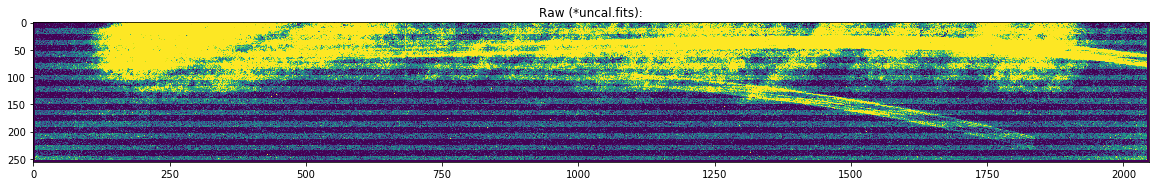

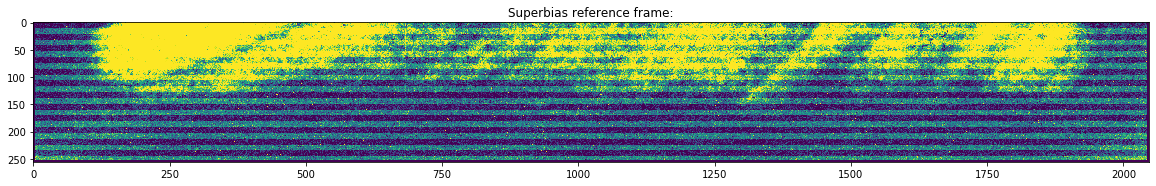

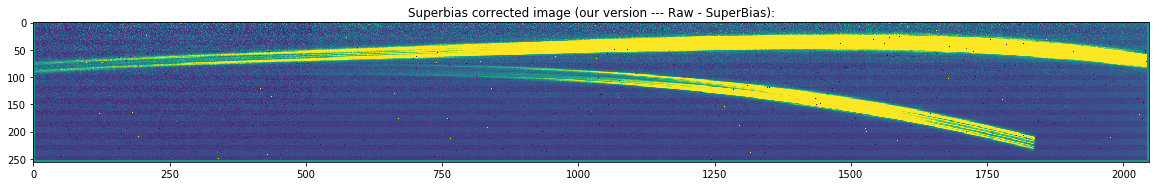

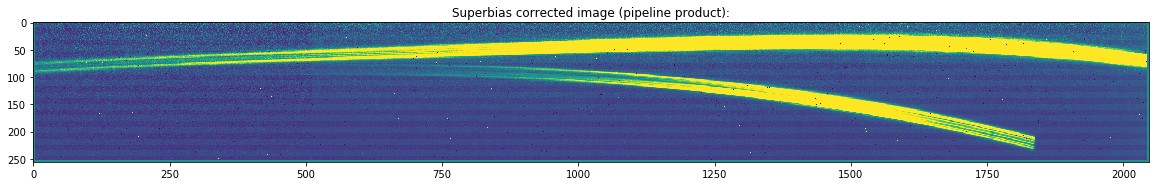

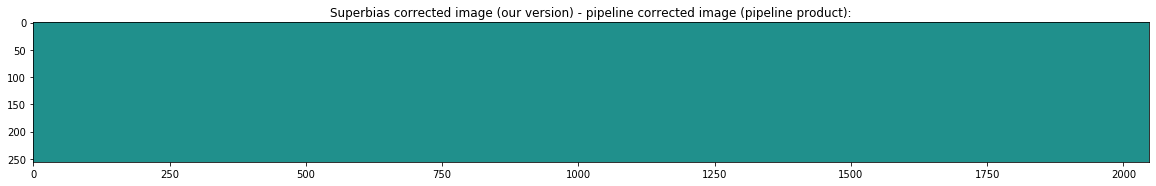

In [14]:
# Load reference file for superbias:
superbias = fits.open('data/jwst_niriss_superbias_0120.fits')
print(superbias['SCI'].data.shape)

# Plot:
plt.figure(figsize=(20,10))
plt.title('Raw (*uncal.fits):')
im = plt.imshow(hdul['SCI'].data[0,2,:,:])
im.set_clim(10000,15000)
plt.figure(figsize=(20,10))
plt.title('Superbias reference frame:')
im = plt.imshow(superbias['SCI'].data)
im.set_clim(10000,15000)
plt.figure(figsize=(20,10))
plt.title('Superbias corrected image (our version --- Raw - SuperBias):')
im = plt.imshow(hdul['SCI'].data[0,2,:,:] - superbias['SCI'].data)
im.set_clim(-1000,1000)
plt.figure(figsize=(20,10))
plt.title('Superbias corrected image (pipeline product):')
im = plt.imshow(hdul_superbias['SCI'].data[0,2,:,:])
im.set_clim(-1000,1000)
plt.figure(figsize=(20,10))
plt.title('Superbias corrected image (our version) - pipeline corrected image (pipeline product):')
sbias_diff = hdul_superbias['SCI'].data[0,2,:,:] - (hdul['SCI'].data[0,2,:,:] - superbias['SCI'].data)
im = plt.imshow(sbias_diff)
im.set_clim(-1,1)

All works as expected from a perspective of the pipeline, so <font color='green'>**we consider the step validated from the NIRISS/SOSS point of view.**</font>

<font color='red'>**One detail, however, is that it is evident there are some remaining even/odd effects in the products**</font>. This is really a problem with `awesimsoss` (see discussion <a href="https://github.com/spacetelescope/awesimsoss/issues/85">here</a>), which ought to be ammended soon, but in the meantime we need to fix because otherwise the pipeline might show weird results in future steps.


The problem has to do with the fact that there is an offset between the zero-level of the bias (the pedestal) and the `awesimoss` products. This is because the `awesimsoss` products have this hardcoded (for now) on the simulations. The consequence of this is that the superbias just doesn't match the actual background/bias level of the simulated images:


Text(0, 0.5, 'Counts')

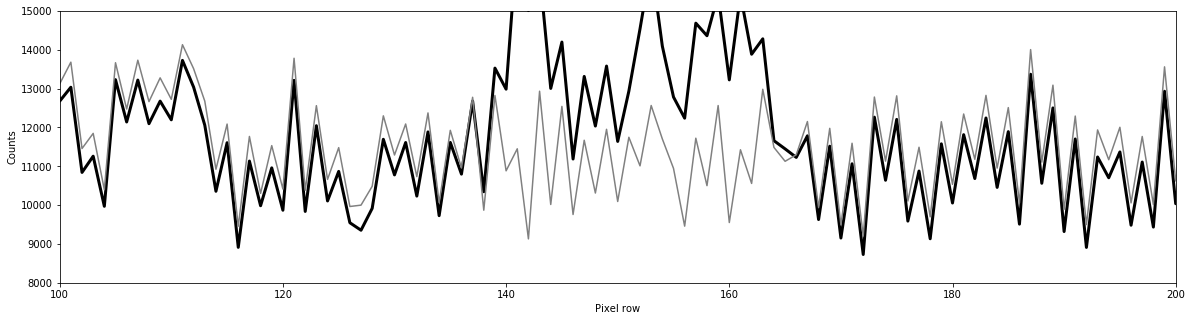

In [151]:
plt.figure(figsize=(20,5))
plt.plot(hdul['SCI'].data[0,2,:,1500],label='Original image',color='black',lw=3)
plt.plot(superbias['SCI'].data[:,1500],label='Original superbias',color='grey')
plt.xlim(100,200)
plt.ylim(8000,15000)
plt.xlabel('Pixel row')
plt.ylabel('Counts')

See how the values outside the profile are not at 0, but around -550? also, the high-frequency ups and downs are not noise; it's actual residual even/odd effects! So, how to solve it? Let's just _empirically_ find this offset. In fact, let's assume the difference is a scaling _and_ an offset, so the image data model is 

$I = a\textrm{Bias} +b$. 

For this, let's use the region between rows 150 to 251 and columns 4 to 1000 (so we stay away from reference pixels), and only use values that have less than 14,000 counts (which tops basically the entire image). Let's simply perform a linear regression between the pixels to scale-and-offset the bias:

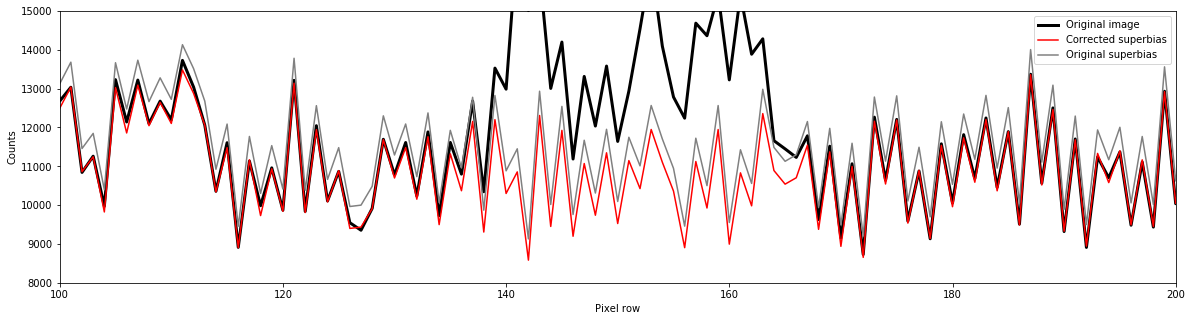

In [150]:
# Flatten pixels --- we don't care were they are really, so eliminate positional info to simplify regression:
I_flattened = hdul['SCI'].data[0,2,150:251,4:1000].flatten()
bias_flattened = superbias['SCI'].data[150:251,4:1000].flatten()
# Mask outliers:
idx_in = np.where((I_flattened<14000)&(bias_flattened<14000))[0]
# Find scaling:
b,a = np.polyfit(bias_flattened[idx_in],I_flattened[idx_in],1)

# Generate corrected bias, being careful to correct non-reference pixels (which are full of zeroes):
corrected_bias = np.zeros(superbias['SCI'].data.shape)
corrected_bias[:-4,4:-4] = b*superbias['SCI'].data[:-4,4:-4] + a

# See how this looks like to compare with previous plot:
plt.figure(figsize=(20,5))
plt.plot(hdul['SCI'].data[0,2,:,1500],label='Original image',color='black',lw=3)
plt.plot(corrected_bias[:,1500],label='Corrected superbias',color='red')
plt.plot(superbias['SCI'].data[:,1500],label='Original superbias',color='grey')
plt.xlim(100,200)
plt.ylim(8000,15000)
plt.xlabel('Pixel row')
plt.ylabel('Counts')
#plt.ylim(-750,750)
plt.legend()

Much better! Now, let's modify the superbias products "by hand", substracting this corrected superbias to the `SaturationStep` products, and saving that data to the `hdul_superbias['SCI'].data`, saving that with a different name:

In [171]:
hdul_superbias_corrected = hdul_superbias.copy()
hdul_superbias_corrected['SCI'].data = hdul_saturation['SCI'].data - corrected_bias

Et voila! Nice. Let's save this to a file: 

In [194]:
if not os.path.exists('output/data_k2-141_superbiasstep_corrected.fits'):
    hdul_superbias_corrected.writeto('output/data_k2-141_superbiasstep_corrected.fits')

## <a id='refpix'> The `refpix` step </a>

This step uses the reference pixels in order to remove some extra counts added around due to readout electronics. These reference pixels are 4-pixel wide strip around the edge of the detector that don't detect light, so they serve to measure these effects. Let's apply this step to the superbias products obtained before (`refpix` assumes this step has been carried out):

In [175]:
calwebb_detector1.refpix_step.RefPixStep.call('output/data_k2-141_superbiasstep_corrected.fits', output_dir='output',save_results=True)

2020-07-27 17:46:13,150 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =   Unknown reference type 'pars-refpixstep'
2020-07-27 17:46:13,153 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2020-07-27 17:46:13,809 - stpipe.RefPixStep - INFO - Step RefPixStep running with args ('output/data_k2-141_superbiasstep_corrected.fits',).
2020-07-27 17:46:13,812 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2020-07-27 17:46:19,022 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2020-07-27 17:46:19,023 - stpipe.RefPixStep - INFO - odd_even_columns = True
2020-07-27 1

<RampModel(308, 3, 256, 2048) from data_k2-141_superbiasstep_corrected_refpixstep.fits>

Let's explore the products:

In [195]:
hdul_refpix = fits.open('output/data_k2-141_superbiasstep_corrected_refpixstep.fits')
print(hdul_refpix.info())

2020-07-27 23:35:02,307 - stpipe - WARNING - /Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.FileIO name='output/data_k2-141_refpixstep.fits' mode='rb' closefd=True>
  """Entry point for launching an IPython kernel.



Filename: output/data_k2-141_superbiasstep_corrected_refpixstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      79   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 3, 308)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 3, 308)   float32   
  5  STAR          1 ImageHDU        10   (1221, 2)   float64   
  6  PLANET        1 ImageHDU        30   (1000, 2)   float64   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [2011B]   
None


All right, there are some changes. It is important to note here, that the reference pixels of our simulations are zeroes, so in theory this step shouldn't do nothing. Let's see what changed in the last group of the first integration, for example:

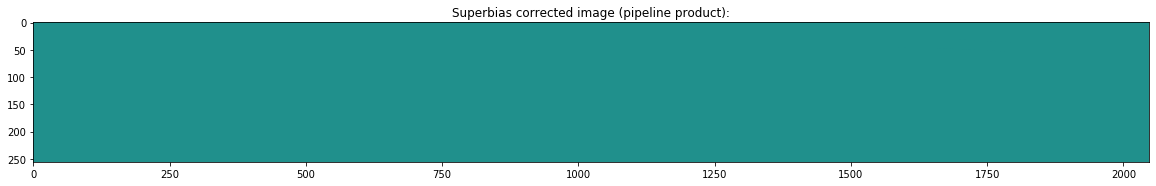

In [196]:
plt.figure(figsize=(20,10))
plt.title('Superbias corrected image (pipeline product):')
im = plt.imshow(hdul_superbias['SCI'].data[0,2,:,:] - hdul_refpix['SCI'].data[0,2,:,:])
im.set_clim(-100,100)

Indeed, it is an array of zeroes. To test the algorithm a bit, let's save a 'fake' product where the two even rows of the reference pixels have a constant non-zero flux in the second group of the first integration only. Let's create this:

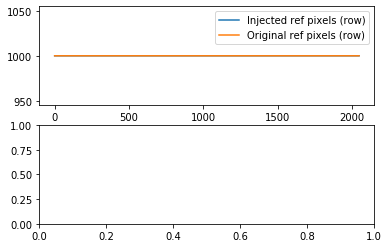

In [201]:
fake_superbias = hdul_superbias
# Adding constant values in the last row:
fake_superbias['SCI'].data[0,2,-1,:] = np.ones(len(hdul_superbias['SCI'].data[0,2,-1,:]))*1000
fake_superbias['SCI'].data[0,2,-3,:] = np.ones(len(hdul_superbias['SCI'].data[0,2,-3,:]))*1000
# Adding constant values on the last column:
#fake_superbias['SCI'].data[0,2,:,-1] = np.ones(len(hdul_superbias['SCI'].data[0,2,:,-1]))*3000
#hdul_superbias = fits.open('output/data_k2-141_superbiasstep.fits')

plt.subplot(211)
plt.plot(fake_superbias['SCI'].data[0,2,-1,:],label='Injected ref pixels (row)')
plt.plot(hdul_superbias['SCI'].data[0,2,-1,:],label='Original ref pixels (row)')
plt.legend()
plt.subplot(212)
#plt.plot(fake_superbias['SCI'].data[0,2,:,-1],label='Injected ref pixels (column)')
#plt.plot(hdul_superbias['SCI'].data[0,2,:,-1],label='Original ref pixels (column)')
#plt.legend()

Now let's save this:

In [202]:
if not os.path.exists('fake_sbiascorrected.fits'):
    fake_superbias.writeto('fake_sbiascorrected.fits')

Let's now run the superbias step on this fake dataset. Let's set `use_side_ref_pixels=False` to simplify the logic of this excercise:

In [203]:
calwebb_detector1.refpix_step.RefPixStep.call('fake_sbiascorrected.fits', output_dir='output',save_results=True)

2020-07-27 23:38:28,950 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =   Unknown reference type 'pars-refpixstep'
2020-07-27 23:38:28,954 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2020-07-27 23:38:29,752 - stpipe.RefPixStep - INFO - Step RefPixStep running with args ('fake_sbiascorrected.fits',).
2020-07-27 23:38:29,754 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2020-07-27 23:38:33,476 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2020-07-27 23:38:33,477 - stpipe.RefPixStep - INFO - odd_even_columns = True
2020-07-27 23:38:33,478 - stpipe.Re

<RampModel(308, 3, 256, 2048) from fake_sbiascorrected_refpixstep.fits>

And let's now repeat the plots made above:

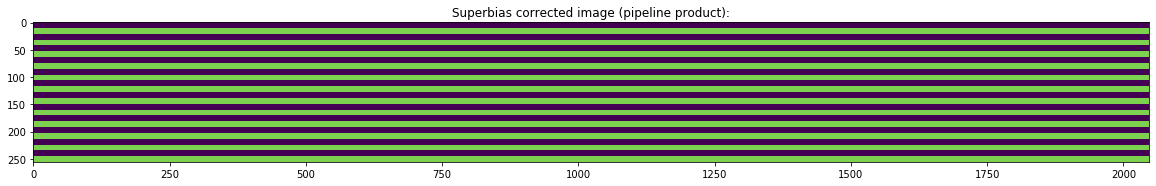

In [204]:
hdul_fake_refpix = fits.open('output/fake_sbiascorrected_refpixstep.fits')
plt.figure(figsize=(20,10))
plt.title('Superbias corrected image (pipeline product):')
refpix_diff = fake_superbias['SCI'].data[0,2,:,:] - hdul_fake_refpix['SCI'].data[0,2,:,:]
im = plt.imshow(refpix_diff)
im.set_clim(0,1000)

Interesting! What is going on? Here, `odd_even_rows = True` --- so there is a different signal being removed on even and odd rows. Initially, I thought that because I added 1000 counts to the last and third-to-last of the reference pixels (an even row filled with 1000), then the average of that particular row is 1000. Now, because the other even row is filled with 1000s as well, the average of both should have been 1000 --- and I thought those were the values that were going to be substracted from each of the even rows. However, when we check the substracted values we find:

In [205]:
print(refpix_diff[:,1000])

[  0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   0.        802.5078125
   0.        802.5078125   0.        802.5078125   

Which I do not understand. There is a step in which the frame is rotated/flipped before doing the correction that might be playing a role here, or it could also be that I misunderstood how the correction works. Either way, moving forward for now.


## <a id='linearity'> The `linearity` step </a>

This step applies the [classical linearity correction](https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/description.html) to the data on a pixel-by-pixel, integration-by-integration, group-by-group manner. Let's apply it to our saturation-flagged (real) products:

In [206]:
calwebb_detector1.linearity_step.LinearityStep.call('output/data_k2-141_superbiasstep_corrected_refpixstep.fits', output_dir='output',save_results=True)

2020-07-27 23:40:28,064 - CRDS - ERROR -  Error determining best reference for 'pars-linearitystep'  =   Unknown reference type 'pars-linearitystep'
2020-07-27 23:40:28,067 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2020-07-27 23:40:28,465 - stpipe.LinearityStep - INFO - Step LinearityStep running with args ('output/data_k2-141_superbiasstep_corrected_refpixstep.fits',).
2020-07-27 23:40:28,467 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-27 23:40:31,716 - stpipe.LinearityStep - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_niriss_linearity_0011.fits
2020-07-27 23:44:04,156 - stpipe.LinearityStep - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not corres

<RampModel(308, 3, 256, 2048) from data_k2-141_superbiasstep_corrected_linearitystep.fits>

Once again, quick exploration of the products:

In [26]:
hdul_linearity = fits.open('output/data_k2-141_superbiasstep_corrected_linearitystep.fits')
print(hdul_linearity.info())

Filename: output/data_k2-141_superbiasstep_corrected_linearitystep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 3, 308)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 3, 308)   float32   
  5  STAR          1 ImageHDU        10   (1221, 2)   float64   
  6  PLANET        1 ImageHDU        30   (1000, 2)   float64   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [2099B]   
None


All looks good! To see how well this is being done, let's once again use the third group of the first integration as a reference. Let's use the NIRISS linearity reference file used by the pipeline to run the corrections ourselves:

In [209]:
# Extract coefficients for our subarray:
linearity_ref = fits.open('data/jwst_niriss_linearity_0011.fits')
coeffs = linearity_ref['COEFFS'].data[:,-256:,:]

# Extract third group of first integration before linearity correction:
third_group = hdul_refpix['SCI'].data[0,2,:,:]
third_group_corrected = np.zeros(third_group.shape)

# Correct for linearity pixel-to-pixel:
for i in range(third_group.shape[0]):
    for j in range(third_group.shape[1]):
        third_group_corrected[i,j] = np.polyval(coeffs[::-1,i,j],third_group[i,j])

2020-07-27 23:44:19,557 - stpipe - WARNING - /Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='data/jwst_niriss_linearity_0011.fits' mode='rb' closefd=True>
  



And let's compare:

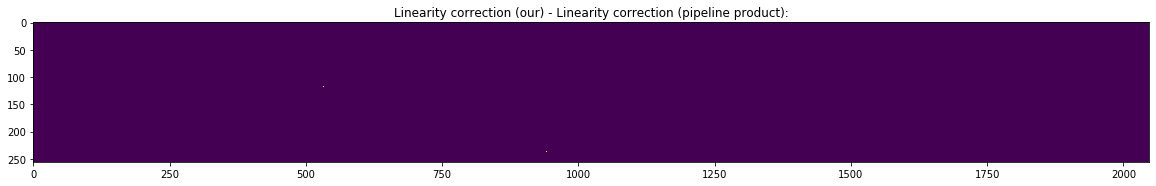

In [210]:
plt.figure(figsize=(20,10))
plt.title('Linearity correction (our) - Linearity correction (pipeline product):')
difference_linearity = third_group_corrected - hdul_linearity['SCI'].data[0,2,:,:]
im = plt.imshow(difference_linearity)
im.set_clim(0,100)

In [211]:
nonzero_values = np.where(difference_linearity.flatten() != 0)[0]
print(len(nonzero_values),'pixels not identical. All the rest give the same result.')
print('(Flattened) Positions:',nonzero_values)

19 pixels not identical. All the rest give the same result.
(Flattened) Positions: [  7527  13697  15314  26776  46535  59783  69842  93079 141889 151300
 158874 172623 203519 240149 247872 303168 314793 484270 486013]


These 19 non-identical pixels were expected (in fact --- we expected 20!). Remember that, above, we discovered 20 saturated pixels were identified on each group --- all but one of them, as expected, were not corrected by the pipeline (but were by our code). The missing pixel, however, is at (flattened) pixel position 162970 (see the [saturation](#saturation) section). That pixel is a bit of a special fella. Let's see what its original value was, and what its corrected value looks like: 

In [212]:
index = 162970
print('Original value:',third_group.flatten()[index])
print('Our corrected value:',third_group_corrected.flatten()[index])
print('Pipeline corrected value:',hdul_linearity['SCI'].data[0,2,:,:].flatten()[index])
print('Coefficients:',coeffs.reshape(6,len(third_group.flatten()))[:,index])

Original value: 220.38281
Our corrected value: 220.3828125
Pipeline corrected value: 220.38281
Coefficients: [ 0.  1. -0. -0. -0.  0.]


That pixel has not only a negative value, but the linearity correction coefficients are basically all zeroes (or very small values, judging from the rest of the coefficients). The only coefficient that is not zero and equal to one is the second, which is the linear coefficient in the polynomial expansion of the linearity correction ($c_0 + c_1F +c_2F^2 ....$, so $c_1$ in this case). This gives this pixel a corrected value equal to its input value, and hence why it was detected as "corrected by the pipeline" with our search above. In reality, the pixel was not touched by the pipeline (as expected, because is marked as saturated), but because our correction gave back the same input value, we didn't detected it above.

Given these results make total sense, <font color='green'>**we consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='dc'> The `darkcurrent` step </a>

This simply substract the dark current signals. Let's run it:

In [213]:
calwebb_detector1.dark_current_step.DarkCurrentStep.call('output/data_k2-141_superbiasstep_corrected_linearitystep.fits', output_dir='output',save_results=True)

2020-07-27 23:44:30,120 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   Unknown reference type 'pars-darkcurrentstep'
2020-07-27 23:44:30,122 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2020-07-27 23:44:30,579 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args ('output/data_k2-141_superbiasstep_corrected_linearitystep.fits',).
2020-07-27 23:44:30,581 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2020-07-27 23:44:33,043 - stpipe.DarkCurrentStep - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_niriss_dark_0114.fits
2020-07-27 23:48:04,390 - stpipe.DarkCurrentStep - INFO - Science data nints

<RampModel(308, 3, 256, 2048) from data_k2-141_superbiasstep_corrected_darkcurrentstep.fits>

Let's look at the products:

In [24]:
hdul_dark = fits.open('output/data_k2-141_superbiasstep_corrected_darkcurrentstep.fits')
print(hdul_dark.info())

Filename: output/data_k2-141_superbiasstep_corrected_darkcurrentstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      89   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 3, 308)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 3, 308)   float32   
  5  STAR          1 ImageHDU        10   (1221, 2)   float64   
  6  PLANET        1 ImageHDU        30   (1000, 2)   float64   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [2175B]   
None


All looks good. Let's see how much changed for the third group on the first integration:

(50, 256, 2048)


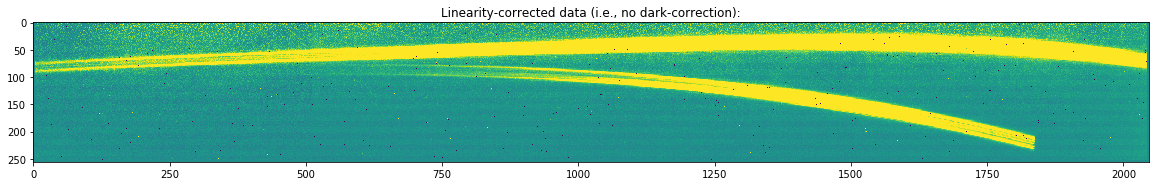

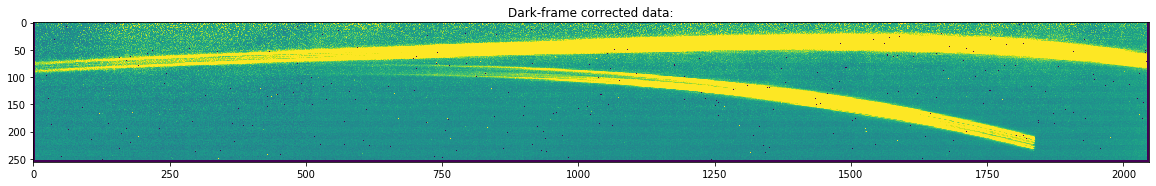

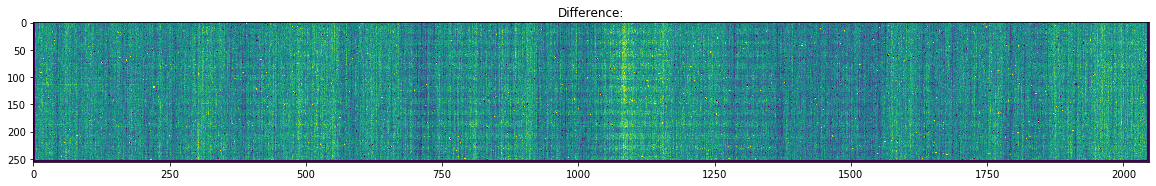

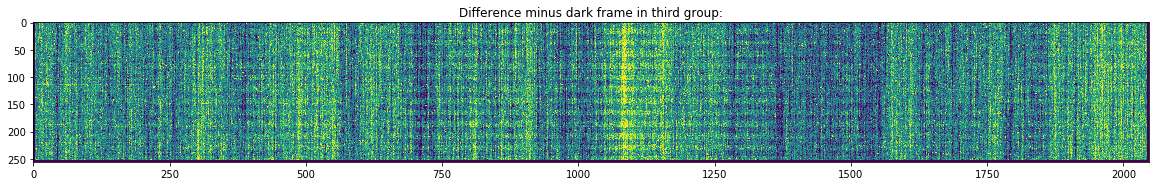

In [28]:
# Load reference file for darks:
darkcurrent = fits.open('data/jwst_niriss_dark_0114.fits')
print(darkcurrent['SCI'].data.shape)

# Plot:
plt.figure(figsize=(20,10))
plt.title('Linearity-corrected data (i.e., no dark-correction):')
im = plt.imshow(hdul_linearity['SCI'].data[0,2,:,:])
im.set_clim(-1000,1000)
plt.figure(figsize=(20,10))
plt.title('Dark-frame corrected data:')
im = plt.imshow(hdul_dark['SCI'].data[0,2,:,:])
im.set_clim(-1000,1000)
plt.figure(figsize=(20,10))
plt.title('Difference:')
im = plt.imshow(hdul_dark['SCI'].data[0,2,:,:] - hdul_linearity['SCI'].data[0,2,:,:])
im.set_clim(-10,10)

plt.figure(figsize=(20,10))
plt.title('Difference minus dark frame in third group:')
im = plt.imshow(hdul_dark['SCI'].data[0,2,:,:] - hdul_linearity['SCI'].data[0,2,:,:] - darkcurrent['SCI'].data[2,:,:])
im.set_clim(-10,10)

2020-08-03 17:10:15,652 - stpipe - WARNING - No handles with labels found to put in legend.


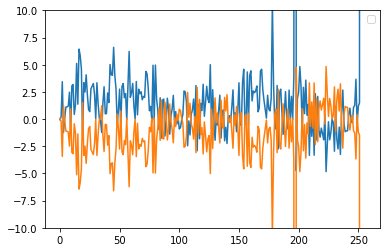

In [46]:
plt.plot(darkcurrent['SCI'].data[2,:,1000]*-)
plt.plot(hdul_dark['SCI'].data[0,2,:,1000] - hdul_linearity['SCI'].data[0,2,:,1000])
plt.ylim([-10,10])
plt.legend()

This is the expected behaviour --- we can see evident, small, vertical strips of signal being removed; these come from the 1/f components of the noise, showing up in the columns as expected for NIRISS/SOSS. Given this shows the expected behaviour, <font color='green'>**we consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='jump'> The `jump` step </a>

This step detects and flags jumps in the ramps. Let's go ahead and run it on our dark-frame corrected data:

In [216]:
calwebb_detector1.jump_step.JumpStep.call('output/data_k2-141_superbiasstep_corrected_darkcurrentstep.fits', output_dir='output',save_results=True)

2020-07-27 23:48:29,397 - CRDS - ERROR -  Error determining best reference for 'pars-jumpstep'  =   Unknown reference type 'pars-jumpstep'
2020-07-27 23:48:29,401 - stpipe.JumpStep - INFO - JumpStep instance created.
2020-07-27 23:48:29,797 - stpipe.JumpStep - INFO - Step JumpStep running with args ('output/data_k2-141_superbiasstep_corrected_darkcurrentstep.fits',).
2020-07-27 23:48:29,799 - stpipe.JumpStep - INFO - Step JumpStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'maximum_cores': None, 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}
2020-07-27 23:48:31,780 - stpipe.JumpStep - INFO - CR rejection threshold = 4 sigma
2020-07-27 23:48:32,072 - stpipe.JumpStep - INFO - Using GAI

2020-07-27 23:50:09,495 - stpipe.JumpStep - INFO - From highest outlier Two point found 132313 pixels with at least one CR
2020-07-27 23:50:10,683 - stpipe.JumpStep - INFO -  working on integration 35
2020-07-27 23:50:10,763 - stpipe.JumpStep - INFO - From highest outlier Two point found 132425 pixels with at least one CR
2020-07-27 23:50:11,914 - stpipe.JumpStep - INFO -  working on integration 36
2020-07-27 23:50:11,995 - stpipe.JumpStep - INFO - From highest outlier Two point found 132216 pixels with at least one CR
2020-07-27 23:50:13,180 - stpipe.JumpStep - INFO -  working on integration 37
2020-07-27 23:50:13,260 - stpipe.JumpStep - INFO - From highest outlier Two point found 132289 pixels with at least one CR
2020-07-27 23:50:14,518 - stpipe.JumpStep - INFO -  working on integration 38
2020-07-27 23:50:14,614 - stpipe.JumpStep - INFO - From highest outlier Two point found 132301 pixels with at least one CR
2020-07-27 23:50:15,774 - stpipe.JumpStep - INFO -  working on integratio

2020-07-27 23:51:03,496 - stpipe.JumpStep - INFO - From highest outlier Two point found 132265 pixels with at least one CR
2020-07-27 23:51:04,904 - stpipe.JumpStep - INFO -  working on integration 76
2020-07-27 23:51:05,010 - stpipe.JumpStep - INFO - From highest outlier Two point found 132325 pixels with at least one CR
2020-07-27 23:51:06,228 - stpipe.JumpStep - INFO -  working on integration 77
2020-07-27 23:51:06,329 - stpipe.JumpStep - INFO - From highest outlier Two point found 132247 pixels with at least one CR
2020-07-27 23:51:07,558 - stpipe.JumpStep - INFO -  working on integration 78
2020-07-27 23:51:07,661 - stpipe.JumpStep - INFO - From highest outlier Two point found 132379 pixels with at least one CR
2020-07-27 23:51:08,883 - stpipe.JumpStep - INFO -  working on integration 79
2020-07-27 23:51:08,979 - stpipe.JumpStep - INFO - From highest outlier Two point found 132250 pixels with at least one CR
2020-07-27 23:51:10,176 - stpipe.JumpStep - INFO -  working on integratio

2020-07-27 23:51:58,004 - stpipe.JumpStep - INFO - From highest outlier Two point found 132436 pixels with at least one CR
2020-07-27 23:51:59,268 - stpipe.JumpStep - INFO -  working on integration 117
2020-07-27 23:51:59,359 - stpipe.JumpStep - INFO - From highest outlier Two point found 132329 pixels with at least one CR
2020-07-27 23:52:00,947 - stpipe.JumpStep - INFO -  working on integration 118
2020-07-27 23:52:01,032 - stpipe.JumpStep - INFO - From highest outlier Two point found 132146 pixels with at least one CR
2020-07-27 23:52:02,227 - stpipe.JumpStep - INFO -  working on integration 119
2020-07-27 23:52:02,310 - stpipe.JumpStep - INFO - From highest outlier Two point found 132411 pixels with at least one CR
2020-07-27 23:52:03,543 - stpipe.JumpStep - INFO -  working on integration 120
2020-07-27 23:52:03,640 - stpipe.JumpStep - INFO - From highest outlier Two point found 132369 pixels with at least one CR
2020-07-27 23:52:05,046 - stpipe.JumpStep - INFO -  working on integr

2020-07-27 23:52:55,670 - stpipe.JumpStep - INFO -  working on integration 157
2020-07-27 23:52:55,758 - stpipe.JumpStep - INFO - From highest outlier Two point found 132343 pixels with at least one CR
2020-07-27 23:52:57,036 - stpipe.JumpStep - INFO -  working on integration 158
2020-07-27 23:52:57,135 - stpipe.JumpStep - INFO - From highest outlier Two point found 132344 pixels with at least one CR
2020-07-27 23:52:58,452 - stpipe.JumpStep - INFO -  working on integration 159
2020-07-27 23:52:58,553 - stpipe.JumpStep - INFO - From highest outlier Two point found 132420 pixels with at least one CR
2020-07-27 23:52:59,849 - stpipe.JumpStep - INFO -  working on integration 160
2020-07-27 23:52:59,944 - stpipe.JumpStep - INFO - From highest outlier Two point found 132280 pixels with at least one CR
2020-07-27 23:53:01,253 - stpipe.JumpStep - INFO -  working on integration 161
2020-07-27 23:53:01,356 - stpipe.JumpStep - INFO - From highest outlier Two point found 132125 pixels with at lea

2020-07-27 23:53:53,054 - stpipe.JumpStep - INFO -  working on integration 198
2020-07-27 23:53:53,155 - stpipe.JumpStep - INFO - From highest outlier Two point found 132178 pixels with at least one CR
2020-07-27 23:53:54,393 - stpipe.JumpStep - INFO -  working on integration 199
2020-07-27 23:53:54,486 - stpipe.JumpStep - INFO - From highest outlier Two point found 132409 pixels with at least one CR
2020-07-27 23:53:55,753 - stpipe.JumpStep - INFO -  working on integration 200
2020-07-27 23:53:55,855 - stpipe.JumpStep - INFO - From highest outlier Two point found 132366 pixels with at least one CR
2020-07-27 23:53:57,065 - stpipe.JumpStep - INFO -  working on integration 201
2020-07-27 23:53:57,167 - stpipe.JumpStep - INFO - From highest outlier Two point found 132280 pixels with at least one CR
2020-07-27 23:53:58,396 - stpipe.JumpStep - INFO -  working on integration 202
2020-07-27 23:53:58,475 - stpipe.JumpStep - INFO - From highest outlier Two point found 132361 pixels with at lea

2020-07-27 23:54:53,570 - stpipe.JumpStep - INFO -  working on integration 239
2020-07-27 23:54:53,664 - stpipe.JumpStep - INFO - From highest outlier Two point found 132332 pixels with at least one CR
2020-07-27 23:54:55,051 - stpipe.JumpStep - INFO -  working on integration 240
2020-07-27 23:54:55,149 - stpipe.JumpStep - INFO - From highest outlier Two point found 132451 pixels with at least one CR
2020-07-27 23:54:56,538 - stpipe.JumpStep - INFO -  working on integration 241
2020-07-27 23:54:56,653 - stpipe.JumpStep - INFO - From highest outlier Two point found 132405 pixels with at least one CR
2020-07-27 23:54:58,105 - stpipe.JumpStep - INFO -  working on integration 242
2020-07-27 23:54:58,201 - stpipe.JumpStep - INFO - From highest outlier Two point found 132231 pixels with at least one CR
2020-07-27 23:54:59,625 - stpipe.JumpStep - INFO -  working on integration 243
2020-07-27 23:54:59,725 - stpipe.JumpStep - INFO - From highest outlier Two point found 132381 pixels with at lea

2020-07-27 23:55:51,901 - stpipe.JumpStep - INFO -  working on integration 280
2020-07-27 23:55:51,985 - stpipe.JumpStep - INFO - From highest outlier Two point found 132369 pixels with at least one CR
2020-07-27 23:55:53,261 - stpipe.JumpStep - INFO -  working on integration 281
2020-07-27 23:55:53,352 - stpipe.JumpStep - INFO - From highest outlier Two point found 132485 pixels with at least one CR
2020-07-27 23:55:54,627 - stpipe.JumpStep - INFO -  working on integration 282
2020-07-27 23:55:54,710 - stpipe.JumpStep - INFO - From highest outlier Two point found 132388 pixels with at least one CR
2020-07-27 23:55:55,988 - stpipe.JumpStep - INFO -  working on integration 283
2020-07-27 23:55:56,068 - stpipe.JumpStep - INFO - From highest outlier Two point found 132257 pixels with at least one CR
2020-07-27 23:55:57,316 - stpipe.JumpStep - INFO -  working on integration 284
2020-07-27 23:55:57,401 - stpipe.JumpStep - INFO - From highest outlier Two point found 132208 pixels with at lea

<RampModel(308, 3, 256, 2048) from data_k2-141_superbiasstep_corrected_jumpstep.fits>

Let's check the products:

In [10]:
hdul_jump = fits.open('output/data_k2-141_superbiasstep_corrected_jumpstep.fits')
print(hdul_jump.info())

Filename: output/data_k2-141_superbiasstep_corrected_jumpstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      98   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 3, 308)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (2048, 256, 3, 308)   uint8   
  4  ERR           1 ImageHDU        11   (2048, 256, 3, 308)   float32   
  5  STAR          1 ImageHDU        10   (1221, 2)   float64   
  6  PLANET        1 ImageHDU        30   (1000, 2)   float64   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [2302B]   
None


All looks good. Now, let's check the `GROUPDQ` of the third group of the first integration, to see if there are any differences, which we will attribute to the jump step detecting jumps:

In [69]:
diff_dark_jump = hdul_dark['GROUPDQ'].data[0,2,:,:] - hdul_jump['GROUPDQ'].data[0,2,:,:]
idx_dark_jump = np.where(diff_dark_jump!=0)
print(len(idx_dark_jump[0]),'detected jumps out of {0:} pixels (i.e., {1:.1f} percent of pixels in group 3)!'.format(2048*256,100*len(idx_dark_jump[0])/(2048*256)))

108873 detected jumps out of 524288 pixels (i.e., 20.8 percent of pixels in group 3)!


Wow, that's a lot of jumps. Let's plot some of them:

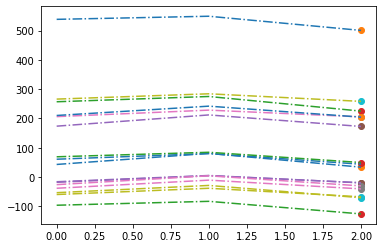

In [90]:
x,y = idx_dark_jump[0],idx_dark_jump[1]
for i in range(len(x)):
    idx = np.where(hdul_jump['GROUPDQ'].data[0,:,x[i],y[i]] == 4)[0]
    plt.errorbar([0,1,2],hdul_jump['SCI'].data[0,:,x[i],y[i]],yerr=hdul_jump['ERR'].data[0,:,x[i],y[i]],fmt='-.')
    plt.plot(idx,hdul_jump['SCI'].data[0,idx,x[i],y[i]],'o')
    if i == 15:
        break

Interesting. Most likely this is due to the errorbars not being calculated correctly to detect the jumps (due to mismatches between the reference files used to generate the data and the ones used by the pipeline, see below for details). We'll revisit this step once this is fixed.

## <a id='ramp_fitting'> The `ramp_fitting` step </a>

This step fits a ramp to the data. Let's go ahead and run it on our jump-product data:

In [35]:
calwebb_detector1.ramp_fit_step.RampFitStep.call('output/data_k2-141_superbiasstep_corrected_jumpstep.fits', output_dir='output',save_results=True)

2020-07-29 17:11:07,047 - CRDS - ERROR -  Error determining best reference for 'pars-rampfitstep'  =   Unknown reference type 'pars-rampfitstep'
2020-07-29 17:11:07,051 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2020-07-29 17:11:07,956 - stpipe.RampFitStep - INFO - Step RampFitStep running with args ('output/data_k2-141_superbiasstep_corrected_jumpstep.fits',).
2020-07-29 17:11:07,958 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': ''}
2020-07-29 17:11:10,746 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_niriss_readnoise_0004.fits
2020-07-29 17:11:29,554 - stpipe.RampFitStep - INFO - Using GAIN reference f

(<ImageModel(256, 2048) from data_k2-141_superbiasstep_corrected_0_rampfitstep.fits>,
 <CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_rampfitstep.fits>)

All seems normal. An important detail here is that there are two outputs: output `*_0_rampfitstep.fits` is the classic "rate" output which weights all the ramps for each integration (i.e., it is a 2D product). Output `*_1_rampfitstep.fits` are the "rateints" products, the slopes of each integration separately. Let's load the products:

In [5]:
hdul_rate = fits.open('output/data_k2-141_superbiasstep_corrected_0_rampfitstep.fits')
print(hdul_rate.info())
hdul_rateints = fits.open('output/data_k2-141_superbiasstep_corrected_1_rampfitstep.fits')
print(hdul_rateints.info())

Filename: output/data_k2-141_superbiasstep_corrected_0_rampfitstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   ()      
  1  SCI           1 ImageHDU        11   (2048, 256)   float32   
  2  ERR           1 ImageHDU        10   (2048, 256)   float32   
  3  DQ            1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 256)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 256)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [2475B]   
None
Filename: output/data_k2-141_superbiasstep_corrected_1_rampfitstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   ()      
  1  SCI           1 ImageHDU        12   (2048, 256, 308)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 308)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 308)   in

All looks good. Note errors have been added to the ramps (`ERR`), as well as `INT_TIMES` (which should save the timestamps of the observations), and variances. To test this step, let's do our own ramp fitting on the `output/data_k2-141_superbiasstep_corrected_jumpstep.fits` products:

In [13]:
def get_slope(x,y,N=3):
    num = N*np.sum(x*y) - np.sum(x)*np.sum(y)
    den = N*np.sum(x**2) - (np.sum(x)**2)
    return num/den

tframe = 5.491 # seconds
times = (np.arange(3)+1)*tframe
if not os.path.exists('output/OurRampFit.npy'):
    data = hdul_jump['SCI'].data
    newramps = np.zeros([data.shape[0],data.shape[2],data.shape[3]])
    print(newramps.shape)
    for t in range(data.shape[0]):
        print('Working on integration number {}'.format(t))
        for i in range(256):
            for j in range(2048):
                fluxes = data[t,:,i,j]
                newramps[t,i,j] = get_slope(times,fluxes)
    np.save('output/OurRampFit.npy',newramps)
else:
    newramps = np.load('output/OurRampFit.npy')

Now let's compare our ramps and the ramps obtained by the pipeline for the first integration:

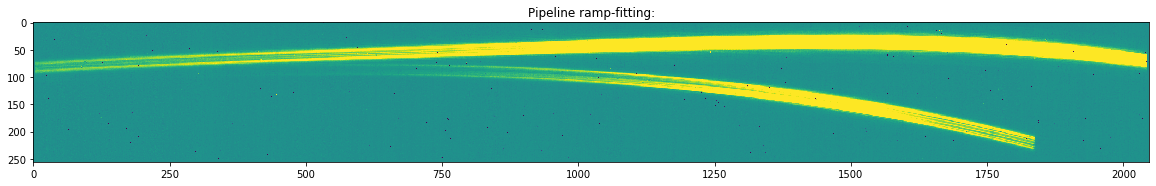

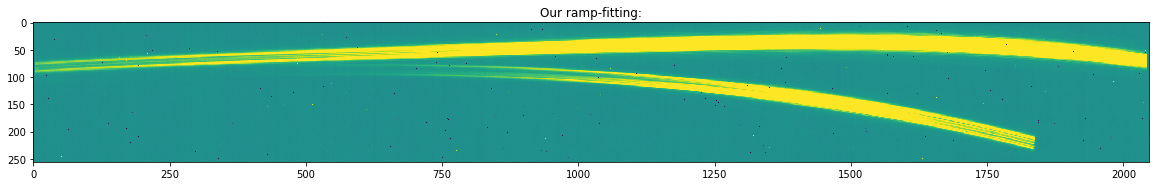

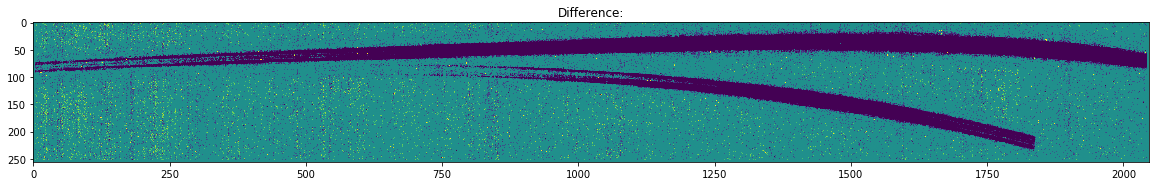

In [7]:
# Plot:
plt.figure(figsize=(20,10))
plt.title('Pipeline ramp-fitting:')
im = plt.imshow(hdul_rateints['SCI'].data[0,:,:])
im.set_clim(-100,100)
plt.figure(figsize=(20,10))
plt.title('Our ramp-fitting:')
im = plt.imshow(newramps[0,:,:])
im.set_clim(-100,100)
plt.figure(figsize=(20,10))
plt.title('Difference:')
im = plt.imshow(hdul_rateints['SCI'].data[0,:,:] - newramps[0,:,:])
im.set_clim(-10,10)

On an order-of-magnitude level, they are very similar. However, there are small differences. Let's make some cuts in the vertical direction to see them at column 1000:

Text(0, 0.5, '$\\Delta$')

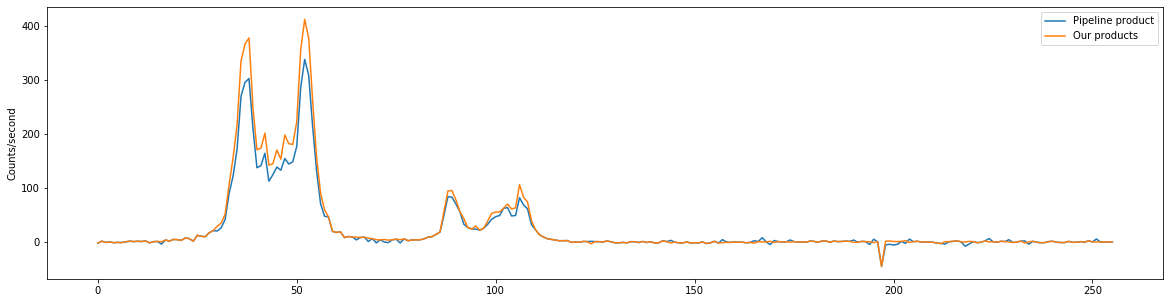

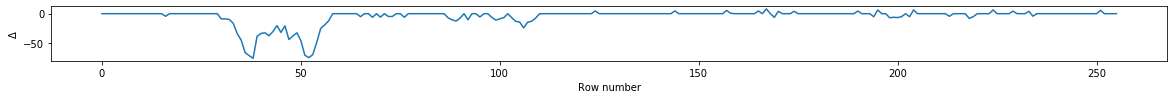

In [8]:
plt.figure(figsize=(20,5))
plt.plot(hdul_rateints['SCI'].data[0,:,1000],label='Pipeline product')
plt.plot(newramps[0,:,1000],label='Our products')
plt.legend()
plt.ylabel('Counts/second')

plt.figure(figsize=(20,1))
plt.plot(hdul_rateints['SCI'].data[0,:,1000] - newramps[0,:,1000])
plt.xlabel('Row number')
plt.ylabel('$\Delta$')

Interesting. It seems that for data outside the profile (i.e., the spikes at rows ~50 and ~100), both results agree. However, it seems as if our rates are slightly larger than the pipeline products for some reason. Let's study one of them from the `jump` products directly. Say, the three groups at row 50:

In [14]:
print('Slope at row 50, column 1000 (our):',newramps[0,50,1000])
print('Slope at row 50, column 1000 (pipeline):',hdul_rateints['SCI'].data[0,50,1000])
print('Counts per group:',hdul_jump['SCI'].data[0,:,50,1000])

Slope at row 50, column 1000 (our): 221.99730151469444
Slope at row 50, column 1000 (pipeline): 176.57266
Counts per group: [ 624.80884 1594.3694  3062.7832 ]


First possibility is that the "effective integration time" counts only the times between groups and not the reset. In that case, the times we used in our own ramps should not include the reset time. Let's see what we get if we take that out from our times:

In [15]:
times_no_reset = (np.arange(3))*tframe
print('Slope at row 50, column 1000, no reset in times (our):',get_slope(times_no_reset,hdul_jump['SCI'].data[0,:,50,1000]))

Slope at row 50, column 1000, no reset in times (our): 221.9973015146945


No dice, same result. What about the `GROUPDQ` flags for this particular pixel? Maybe some kind of bad pixel was detected?

In [16]:
print(hdul_jump['GROUPDQ'].data[0,:,50,1000])

[0 0 4]


OK, so nothing with the first two groups, but the third group shows a `GROUPDQ` <a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html?highlight=dq%20flags#data-quality-flags">equals to 4 which means it is being flagged by the jump step</a>. What if we try getting the slopes only with the first two groups then?

In [30]:
print('Slope at row 50, column 1000, only first two groups:',get_slope(x,y,N=2))

176.572672896558
Slope at row 50, column 1000, only first two groups: 176.572672896558


Jackpot! This is, basically, $(y_2-y_2)/(t_2-t_1)$. Now, let's try to ammend that, run the ramps again and check but being careful with `GROUPDQ` flags. Anything other than 0 is not considered; also, we don't consider the reset time:

In [31]:
tframe = 5.491 # seconds
times = np.arange(3)*tframe
if not os.path.exists('output/OurNewRampFit.npy'):
    data = hdul_jump['SCI'].data
    groupdq = hdul_jump['GROUPDQ'].data
    newramps2 = np.zeros([data.shape[0],data.shape[2],data.shape[3]])
    for t in range(data.shape[0]):
        print('Working on integration number {}'.format(t))
        for i in range(256):
            for j in range(2048):
                dqs = groupdq[t,:,i,j]
                fluxes = data[t,:,i,j]
                dq_zero = np.where(dqs==0)[0]
                nzeros = len(dq_zero)
                if nzeros == 3:
                    newramps2[t,i,j] = get_slope(times,fluxes)
                else:
                    newramps2[t,i,j] = get_slope(times[dq_zero],fluxes[dq_zero],N=nzeros)
    np.save('output/OurNewRampFit.npy',newramps)
else:
    newramps2 = np.load('output/OurNewRampFit.npy')

Working on integration number 0


2020-07-29 00:23:26,861 - stpipe - WARNING - /Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.



Working on integration number 1
Working on integration number 2
Working on integration number 3
Working on integration number 4
Working on integration number 5
Working on integration number 6
Working on integration number 7
Working on integration number 8
Working on integration number 9
Working on integration number 10
Working on integration number 11
Working on integration number 12
Working on integration number 13
Working on integration number 14
Working on integration number 15
Working on integration number 16
Working on integration number 17
Working on integration number 18
Working on integration number 19
Working on integration number 20
Working on integration number 21
Working on integration number 22
Working on integration number 23
Working on integration number 24
Working on integration number 25
Working on integration number 26
Working on integration number 27
Working on integration number 28
Working on integration number 29
Working on integration number 30
Working on integrat

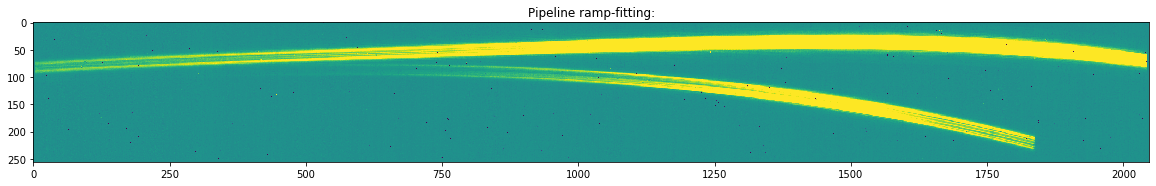

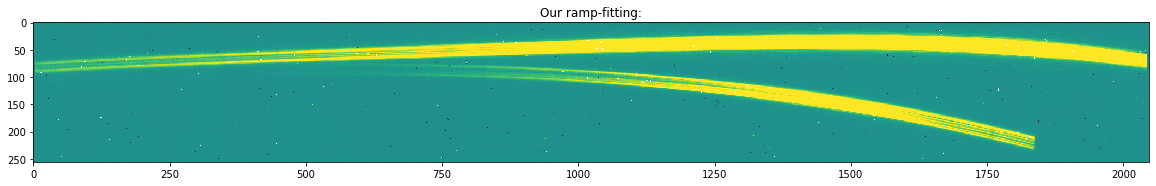

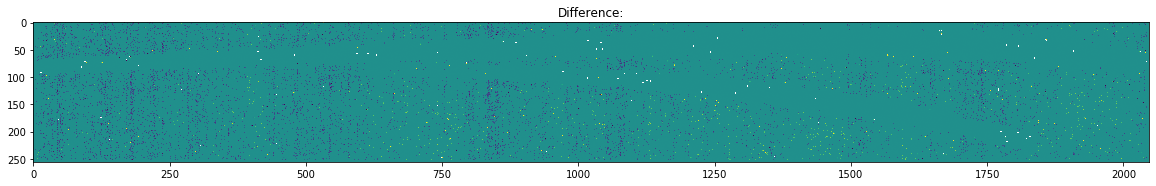

In [32]:
# Plot:
plt.figure(figsize=(20,10))
plt.title('Pipeline ramp-fitting:')
im = plt.imshow(hdul_rateints['SCI'].data[0,:,:])
im.set_clim(-100,100)
plt.figure(figsize=(20,10))
plt.title('Our ramp-fitting:')
im = plt.imshow(newramps2[0,:,:])
im.set_clim(-100,100)
plt.figure(figsize=(20,10))
plt.title('Difference:')
im = plt.imshow(hdul_rateints['SCI'].data[0,:,:] - newramps2[0,:,:])
im.set_clim(-10,10)

Almost perfect!

Text(0, 0.5, '$\\Delta$')

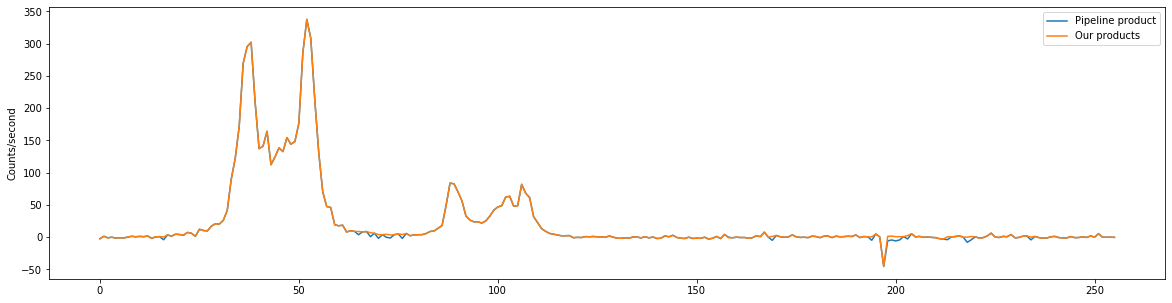

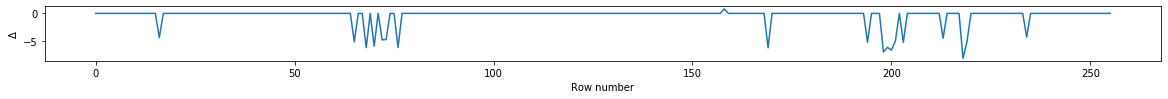

In [33]:
plt.figure(figsize=(20,5))
plt.plot(hdul_rateints['SCI'].data[0,:,1000],label='Pipeline product')
plt.plot(newramps2[0,:,1000],label='Our products')
plt.legend()
plt.ylabel('Counts/second')

plt.figure(figsize=(20,1))
plt.plot(hdul_rateints['SCI'].data[0,:,1000] - newramps2[0,:,1000])
plt.xlabel('Row number')
plt.ylabel('$\Delta$')

So --- what's with the rows with "spikes"? Let's check row 200 in the same way as above:

In [46]:
print('Slope at row 200, column 1000 (our):',newramps2[0,200,1000])
print('Slope at row 200, column 1000 (pipeline):',hdul_rateints['SCI'].data[0,200,1000])
print('(Corrected) counts per group:',hdul_jump['SCI'].data[0,:,200,1000])
print(hdul_jump['GROUPDQ'].data[0,:,200,1000])

Slope at row 200, column 1000 (our): 0.7894346132627544
Slope at row 200, column 1000 (pipeline): -5.768356
(Corrected) counts per group: [48.1126   88.45621  56.782166]
[0 4 0]


Interesting. The pixel being flagged by the jump detection algorithm is the one in the middle. But why the slope calculated by the pipeline is negative? Solution: the ramp-fitting routine assumes this is a cosmic-ray hit. Thus, it takes the second and third groups as good measures of the ramp, and calculates the slope using those two. This gives:

$(G_3-G_2)/(FT) = (56.782166 - 88.45621)/5.491 \approx -5.768356$

With $FT$ being a frame-time. 

So --- what happened here? Most likely, the second group "jump" was just a statistical fluctuation that was flagged as a jump. The reason might have been a mismatch between the reference files used to generate the awesimsoss data (a known problem on the works --- see <a href="https://github.com/spacetelescope/awesimsoss/issues/85">this issue</a> and <a href="https://github.com/spacetelescope/awesimsoss/pull/86">this commit</a>). Once that's fixed, we will revisit this. In any case, it is sensible to ask if this is what the pipeline _should_ be doing. It makes sense the pipeline uses groups 2 and 3 to calculate a ramp if the hit was indeed a cosmic ray, but cases like this could happen due to statistical fluctuations being flagged as jumps. Shouldn't the ramp-fit check if the signal in group 3 is larger than the signal in group 2 and _if_ that is true, apply this methodology? Currently discussing this internally (via Slack) with Pipeline devs.

In the meantime, this step of the pipeline shows the expected behaviour, so <font color='green'>**we consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='gain_scale'> The `gain_scale` step </a>

We note this step only applies to NIRSpec, so it should be skipped. Let's test this:

In [92]:
calwebb_detector1.gain_scale_step.GainScaleStep.call('output/data_k2-141_superbiasstep_corrected_1_rampfitstep.fits', output_dir='output',save_results=True)

2020-07-30 00:02:01,154 - CRDS - ERROR -  Error determining best reference for 'pars-gainscalestep'  =   Unknown reference type 'pars-gainscalestep'
2020-07-30 00:02:01,158 - stpipe.GainScaleStep - INFO - GainScaleStep instance created.
2020-07-30 00:02:01,508 - stpipe.GainScaleStep - INFO - Step GainScaleStep running with args ('output/data_k2-141_superbiasstep_corrected_1_rampfitstep.fits',).
2020-07-30 00:02:01,510 - stpipe.GainScaleStep - INFO - Step GainScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-30 00:02:29,840 - stpipe.GainScaleStep - INFO - GAINFACT not found in gain reference file
2020-07-30 00:02:29,841 - stpipe.GainScaleStep - INFO - Step will be skipped
2020-07-30 00:02:36,612 - stpipe.GainScaleStep - INFO - Saved model in output/dat

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_gainscalestep.fits>

Indeed, it is properly skipped (really because there is no `GAINFACT` in the headers).